# Ejercicio 5 — Efecto de características estructurales sobre la rentabilidad operativa

**Objetivo**  
Analizar el efecto de características estructurales (país, sector, tamaño, año) sobre `EBITDA_Ingresos_netos` y construir un modelo **predictivo** (árbol de regresión). Finalmente, estimar el **CATE** del tratamiento *Leverage alto vs bajo* controlando por el resto de variables observables.

**Variables**
- **Target**: `EBITDA_Ingresos_netos`
- **Categóricas**: `country`, `year`, `sector`, `size`
- **Numéricas**: `total_assets`, `Solvencia`, `Leverage`

**Índice de trabajo**
1. Preparación del entorno.
2. Carga y verificación de datos
3. Análisis descriptivo (EDA): categóricas vs numéricas
4. Modelo lineal con características estructurales (country, sector, size, year)
5. Modelo predictivo (árbol de regresión): métricas e importancia
6. Efecto causal de `Leverage` (CATE alto vs bajo) con árboles
7. Resultados por subgrupos (país, sector, tamaño)
8. Conclusiones

## 1.Preparación del entorno

En este apartado configuramos el entorno de trabajo para que el notebook sea **portable** y pueda ejecutarse tanto en **Google Drive** como en local.  
Para ello utilizamos dos banderas:

- **`USE_DRIVE`**: controla si trabajamos con archivos almacenados en Google Drive (`True`) o en el directorio local (`False`).
- **`RUN_MODELING`**: determina si el notebook debe ejecutar el **procesado y entrenamiento completo** (`True`) o, en modo entrega (`False`), cargar directamente los resultados y artefactos previamente guardados.

Además:
- Definimos la **estructura de carpetas** para mantener organizados datos, salidas y scripts.
- Creamos un **README** que documenta el contenido y uso de cada carpeta.
- Cargamos **todas las librerías necesarias** en una única celda.
- Configuramos un **estilo gráfico consistente** que usaremos en todos los gráficos.

Con esta preparación aseguramos un flujo de trabajo reproducible y ordenado desde el inicio del ejercicio.

In [27]:
#Flags, rutas base y (si aplica) montaje de Drive

# === Flags ===
USE_DRIVE    = False   # Trabajo habitual en Drive (entrega → False)
RUN_MODELING = False   # Generar artefactos (entrega → False, solo cargar)

from pathlib import Path

# === Definición de rutas base ===
if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        ROOT = Path("/content/drive/MyDrive/MASTER BIG DATA/md2_2025")
    except Exception as e:
        print("No se pudo montar Drive. Trabajaremos en local.")
        USE_DRIVE = False

if not USE_DRIVE:
    ROOT = Path(".").resolve()

# Carpeta del ejercicio
EJ5 = ROOT / "ej5_finanzas_causal_predictivo"

# Diccionario de rutas
PATHS = {
    "ej":          str(EJ5),
    "nb":          str(EJ5 / "notebooks"),
    "src":         str(EJ5 / "src"),
    "data_raw":    str(EJ5 / "data" / "raw"),
    "data_proc":   str(EJ5 / "data" / "processed"),
    "out_csv":     str(EJ5 / "outputs" / "csv"),
    "out_figs":    str(EJ5 / "outputs" / "figures"),
    "out_models":  str(EJ5 / "outputs" / "models"),
    "docs":        str(EJ5 / "docs"),
    "scripts":     str(EJ5 / "scripts"),
}

print("Flags → USE_DRIVE =", USE_DRIVE, "| RUN_MODELING =", RUN_MODELING)
print("Raíz de trabajo:", ROOT)
print("Carpeta del ejercicio:", EJ5)

Flags → USE_DRIVE = False | RUN_MODELING = False
Raíz de trabajo: /content
Carpeta del ejercicio: /content/ej5_finanzas_causal_predictivo


In [2]:
# 2) Estructura de carpetas y README del ejercicio
def ensure_dir(p: str):
    Path(p).mkdir(parents=True, exist_ok=True)

# Crear estructura
for k in ("nb","src","data_raw","data_proc","out_csv","out_figs","out_models","docs","scripts"):
    ensure_dir(PATHS[k])

# Crear README con descripción
readme_path = Path(PATHS["ej"]) / "README.md"
readme_text = """# Ejercicio 5 — Efecto de características estructurales sobre la rentabilidad operativa

Este proyecto analiza el impacto de variables estructurales (país, sector, tamaño, año) sobre la rentabilidad operativa (`EBITDA_Ingresos_netos`),
construye un modelo predictivo (árbol de regresión) y estima el efecto causal (CATE) de `Leverage alto vs bajo`, controlando por observables.

**Notebook principal:** notebooks/Ej5_finanzas.ipynb, abrelo para ejecutar el flujo completo del ejercicio siguiendo las instrucciones.
**Datos (no incluidos):** coloca el fichero de datos en `data/raw/` (CSV o Excel).
**Modo trabajo:** `USE_DRIVE=True`, `RUN_MODELING=True` para generar artefactos.
**Modo entrega:** `USE_DRIVE=False`, `RUN_MODELING=False` para cargar artefactos desde `outputs/`.

**Estructura:**
- `data/raw/`       → datos originales
- `data/processed/` → datos limpios / transformados
- `outputs/csv/`    → tablas de resultados (métricas, importancias, CATE, etc.)
- `outputs/figures/`→ gráficos (EDA, árbol, subgrupos)
- `outputs/models/` → modelos guardados (árbol, preprocesamiento)
- `docs/`           → documentación auxiliar

**Notas:**
- El árbol predictivo usará `country`, `year`, `sector`, `size`, `total_assets`, `Solvencia`, `Leverage`.
- Para CATE definiremos `Leverage alto` vs `bajo` y estimaremos efectos heterogéneos por subgrupos.
"""
if not readme_path.exists():
    readme_path.write_text(readme_text, encoding="utf-8")
    print("README creado en:", readme_path)
else:
    print("README ya existía en:", readme_path)

print("Estructura verificada. Directorios clave:")
for k in ("data_raw","data_proc","out_csv","out_figs","out_models"):
    print(f"  {k:>10} → {PATHS[k]}")

README ya existía en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/README.md
Estructura verificada. Directorios clave:
    data_raw → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/data/raw
   data_proc → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/data/processed
     out_csv → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/outputs/csv
    out_figs → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/outputs/figures
  out_models → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/outputs/models


In [3]:
# 3) Imports únicos y estilo gráfico
import os, json, warnings, random
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from scipy.stats.mstats import winsorize
from scipy.stats import randint

# Lineal (explicativo)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Persistencia
import joblib

# Estilo gráfico consistente
sns.set_theme(style='whitegrid', palette='Set2', context='talk')

# Aleatoriedad controlada
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Opciones de impresión
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)

print("Librerías cargadas. SEED =", SEED)

Librerías cargadas. SEED = 42


## 2.Carga y limpieza inicial de datos

En este paso leemos el fichero `empresas.csv` (separador `;`), normalizamos y renombramos **todas las columnas al inglés** siguiendo un formato consistente en minúsculas y `snake_case`.  
Esto garantiza que todo el flujo de trabajo utilice nombres homogéneos, evitando mezclas de idiomas o formatos.

Además:
- Verificamos tipos de variables, distinguiendo entre **categóricas** y **numéricas**.
- Convertimos correctamente `year` a entero y magnitudes/ratios a numérico.
- Guardamos una versión limpia y estable en `data/processed/empresas_limpio.csv`.

**Entrada**: `data/raw/empresas.csv`  
**Salida**: `data/processed/empresas_limpio.csv`  
**Objetivo**: disponer de un dataset coherente para el EDA, el modelo lineal, el árbol de regresión y la estimación causal (CATE).

In [4]:
# 2) Carga y limpieza inicial de datos

import unicodedata

RAW_PATH = Path(PATHS["data_raw"]) / "empresas.csv"
PROC_PATH = Path(PATHS["data_proc"]) / "empresas_limpio.csv"

def _normalize_colname(s: str) -> str:
    # minúsculas, sin tildes, reemplazo de espacios y símbolos por "_"
    s = s.strip().lower()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    for ch in [' ', '-', '/', '\\', '(', ')', '.', ',', '%']:
        s = s.replace(ch, '_')
    s = s.replace('__', '_')
    return s

# 1) Lectura con separador correcto
df_raw = pd.read_csv(RAW_PATH, sep=';', dtype=str)

# 2) Normalizar nombres base
df_raw.columns = [_normalize_colname(c) for c in df_raw.columns]

# 3) Renombrado completo a inglés
rename_map = {
   'pais': 'country',
    'anio': 'year',
    'sector': 'sector',
    'tamanio': 'size',
    'total_activos': 'total_assets',
    'facturacion': 'revenue',
    'valor_bruto_agregado': 'gross_value_added',
    'trabajadores': 'num_employees',
    'solvencia': 'solvency',
    'apalancamiento': 'leverage',
    'liquidez': 'liquidity',
    'ebitda_ingresos_netos': 'ebitda_net_income',
    'beneficio_econ_ingresos_netos': 'economic_profit_net_income',
    'ebit_ingresos_netos': 'ebit_net_income',
    'rotacion_activos': 'asset_turnover',
    'salarios_va': 'wages_gva'
}

# Aplicar renombrado para las columnas presentes
df_raw = df_raw.rename(columns={c: rename_map.get(c, c) for c in df_raw.columns})

# 4) Definir categóricas y numéricas
cat_cols = [c for c in ['country', 'year', 'sector', 'size'] if c in df_raw.columns]
num_cols_candidates = [
    'total_assets', 'revenue', 'gross_value_added', 'num_firms', 'num_employees',
    'ebitda_net_income', 'economic_profit_net_income', 'ebit_net_income',
    'asset_turnover', 'wages_gva', 'solvency', 'leverage', 'liquidity'
]
num_cols = [c for c in num_cols_candidates if c in df_raw.columns]

# Convertir year a entero
if 'year' in df_raw.columns:
    df_raw['year'] = pd.to_numeric(df_raw['year'], errors='coerce').astype('Int64')

# Convertir numéricas
for c in num_cols:
    df_raw[c] = (df_raw[c]
                 .str.replace(',', '.', regex=False)
                 .str.replace(' ', '', regex=False)
                 .str.replace('%', '', regex=False)
                 )
    df_raw[c] = pd.to_numeric(df_raw[c], errors='coerce')

# Limpiar espacios en categóricas
for c in cat_cols:
    df_raw[c] = df_raw[c].astype(str).str.strip()

# 5) Reporte rápido
print("Columnas después de limpieza y renombrado:")
print(df_raw.columns.tolist())
print("\nTipos inferidos:")
print(df_raw[cat_cols + num_cols].dtypes if (cat_cols or num_cols) else df_raw.dtypes)

print("\nResumen de nulos en variables clave:")
keys = list(dict.fromkeys(['ebitda_net_income', 'solvency', 'leverage', 'total_assets'] + cat_cols))
keys = [k for k in keys if k in df_raw.columns]
print(df_raw[keys].isna().sum().sort_values(ascending=False).head(12))

# 6) Guardar procesado
df_raw.to_csv(PROC_PATH, index=False, encoding='utf-8')
print("\n✅ Dataset limpio guardado en:", PROC_PATH)

# Nota: En RUN_MODELING=False cargaremos directamente PROC_PATH.

Columnas después de limpieza y renombrado:
['country', 'year', 'sector', 'size', 'total_assets', 'revenue', 'gross_value_added', 'num_employees', 'solvency', 'leverage', 'liquidity', 'ebitda_net_income', 'economic_profit_net_income', 'ebit_net_income', 'asset_turnover', 'wages_gva']

Tipos inferidos:
country                        object
year                           object
sector                         object
size                           object
total_assets                    int64
revenue                         int64
gross_value_added               int64
num_employees                   int64
ebitda_net_income             float64
economic_profit_net_income    float64
ebit_net_income               float64
asset_turnover                float64
wages_gva                     float64
solvency                      float64
leverage                      float64
liquidity                     float64
dtype: object

Resumen de nulos en variables clave:
ebitda_net_income    0
solvency       

## 3.Análisis Descriptivo (EDA)

En este apartado realizamos un análisis exploratorio de los datos, combinando para cada tipo de variable (categórica y numérica) tanto un resumen tabular como visualizaciones gráficas.  
El objetivo es identificar patrones generales, valores atípicos y posibles problemas de calidad de datos que puedan influir en los modelos posteriores.


### 3.1Variables categóricas

Para las variables categóricas (`country`, `year`, `sector`, `size`) mostraremos:

- **Tablas de frecuencia**: número absoluto de registros y porcentaje de cada categoría.
- **Gráficos de barras**: frecuencia por categoría, ordenadas de mayor a menor, para identificar categorías dominantes o poco representadas.



📊 Frecuencia para country:
  country  count  percentage
0      ES    180        50.0
1      FR    180        50.0

📊 Frecuencia para year:
    year  count  percentage
0   2000     18         5.0
1   2001     18         5.0
2   2002     18         5.0
3   2003     18         5.0
4   2004     18         5.0
5   2005     18         5.0
6   2006     18         5.0
7   2007     18         5.0
8   2008     18         5.0
9   2009     18         5.0
10  2010     18         5.0
11  2011     18         5.0
12  2012     18         5.0
13  2013     18         5.0
14  2014     18         5.0
15  2015     18         5.0
16  2016     18         5.0
17  2017     18         5.0
18  2018     18         5.0
19  2019     18         5.0

📊 Frecuencia para sector:
  sector  count  percentage
0      C    120   33.333333
1      F    120   33.333333
2      G    120   33.333333

📊 Frecuencia para size:
   size  count  percentage
0     1    120   33.333333
1     2    120   33.333333
2     3    120   33.333333


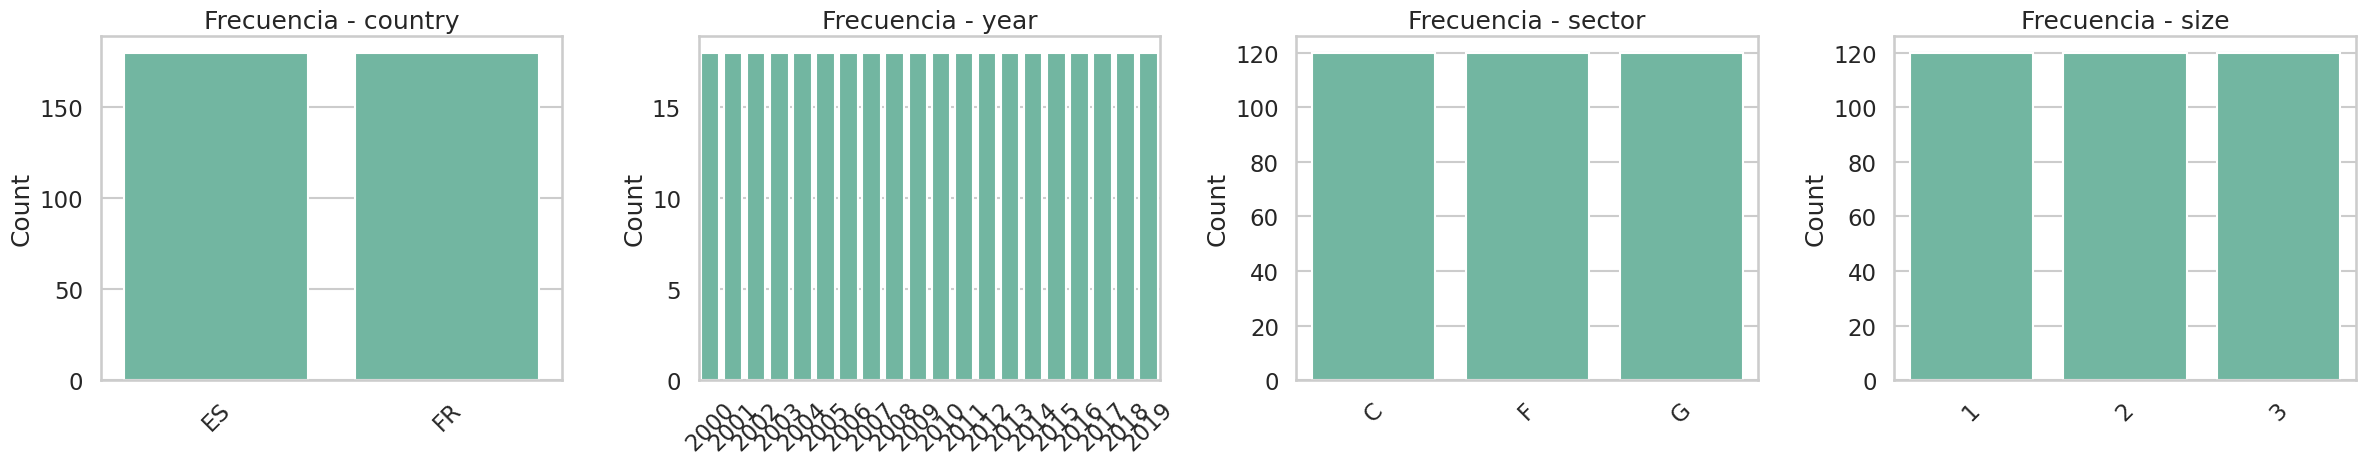

In [5]:
# 3.1 EDA - Variables categóricas
# Cargar dataset limpio
df = pd.read_csv(Path(PATHS["data_proc"]) / "empresas_limpio.csv")

# Definir variables categóricas
cat_vars = ['country', 'year', 'sector', 'size']
cat_vars = [c for c in cat_vars if c in df.columns]

# Tabla de frecuencias por variable categórica
for col in cat_vars:
    freq_table = df[col].value_counts(dropna=False).reset_index()
    freq_table.columns = [col, 'count']
    freq_table['percentage'] = 100 * freq_table['count'] / len(df)
    print(f"\n📊 Frecuencia para {col}:")
    print(freq_table)

# Gráficos en grid
sns.set_theme(style='whitegrid', palette='Set2', context='talk')
fig, axes = plt.subplots(nrows=1, ncols=len(cat_vars), figsize=(6*len(cat_vars), 5))

if len(cat_vars) == 1:
    axes = [axes]  # Para iterar si solo hay 1 variable

for ax, col in zip(axes, cat_vars):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order, ax=ax)
    ax.set_title(f"Frecuencia - {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.2Variables numéricas

Para las variables numéricas (`total_assets`, `revenue`, `gross_value_added`, `num_employees`, `solvency`, `leverage`, `liquidity`, `ebitda_net_income`, `economic_profit_net_income`, `ebit_net_income`, `asset_turnover`, `wages_gva`) mostraremos:

- **Tabla de estadísticos descriptivos**: recuento, media, desviación estándar, mínimo, máximo y percentiles 25, 50 y 75.
- **Visualizaciones combinadas**:
  - **Histogramas**: para observar la distribución de los valores.
  - **Boxplots**: para identificar valores atípicos.
  - Ambos gráficos se presentarán en un mismo grid para facilitar la comparación.

El análisis descriptivo nos permitirá establecer una primera impresión sobre la dispersión, simetría y posibles sesgos en los datos, así como detectar categorías con muy baja frecuencia o valores extremos.

📊 Estadísticos descriptivos de variables numéricas:
                            count          mean           std         min           25%           50%           75%  \
total_assets                360.0  1.004455e+08  1.164117e+08  7699933.00  3.685923e+07  6.354241e+07  9.747878e+07   
revenue                     360.0  1.419982e+08  1.788487e+08  3793092.00  3.772620e+07  7.264614e+07  1.754313e+08   
gross_value_added           360.0  2.508256e+07  2.497015e+07  1238913.00  9.404114e+06  1.821432e+07  3.029181e+07   
num_employees               360.0  4.458812e+05  3.287147e+05    23373.00  1.652760e+05  4.402175e+05  5.576855e+05   
solvency                    360.0  3.243976e+02  2.075601e+02      188.07  2.447075e+02  2.791150e+02  3.240350e+02   
leverage                    360.0  2.243974e+02  2.075603e+02       88.07  1.447075e+02  1.791150e+02  2.240350e+02   
liquidity                   360.0  6.642750e+01  9.996647e+00       40.14  5.913500e+01  6.818000e+01  7.391750e+01

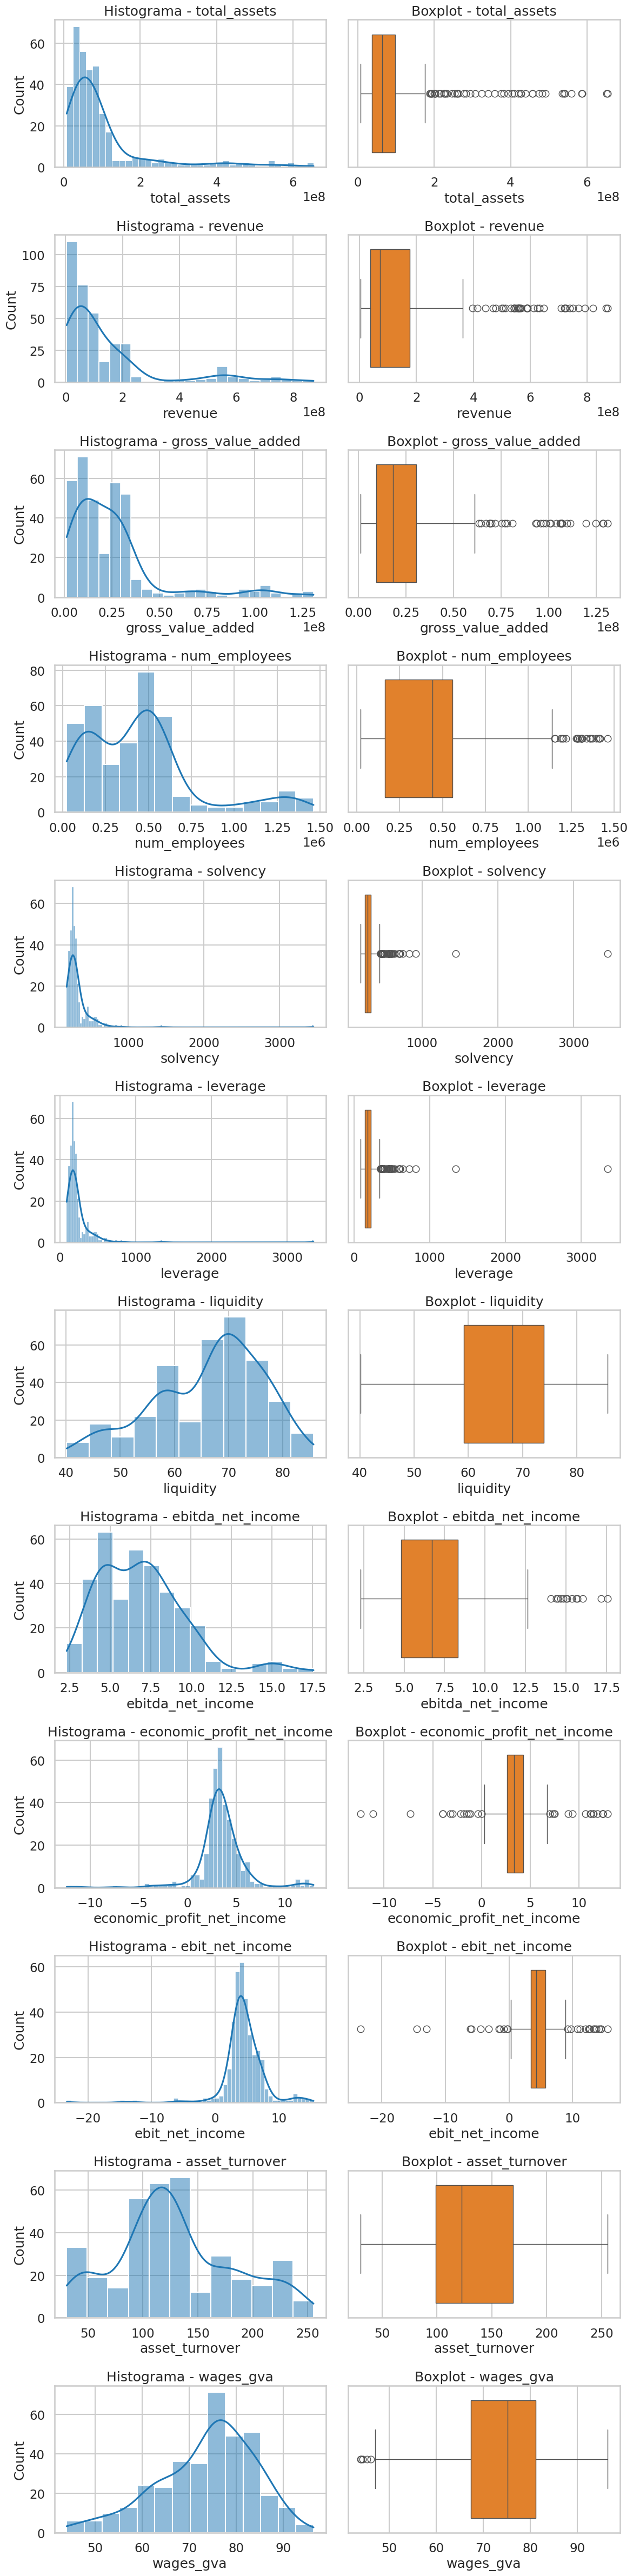

In [6]:
# 3.2 EDA - Variables numéricas

# Definir variables numéricas
num_vars = [
    'total_assets', 'revenue', 'gross_value_added', 'num_employees',
    'solvency', 'leverage', 'liquidity', 'ebitda_net_income',
    'economic_profit_net_income', 'ebit_net_income', 'asset_turnover', 'wages_gva'
]
num_vars = [c for c in num_vars if c in df.columns]

# Tabla de estadísticos descriptivos
desc_table = df[num_vars].describe().transpose()
print("📊 Estadísticos descriptivos de variables numéricas:")
print(desc_table)

# Gráficos combinados (histograma + boxplot por variable)
sns.set_theme(style='whitegrid', palette='Set2', context='talk')

fig, axes = plt.subplots(nrows=len(num_vars), ncols=2, figsize=(12, 4*len(num_vars)))

for i, col in enumerate(num_vars):
    # Histograma
    sns.histplot(data=df, x=col, kde=True, ax=axes[i,0], color='tab:blue')
    axes[i,0].set_title(f"Histograma - {col}")

    # Boxplot
    sns.boxplot(data=df, x=col, ax=axes[i,1], color='tab:orange')
    axes[i,1].set_title(f"Boxplot - {col}")

plt.tight_layout()
plt.show()

El conjunto de datos presenta un equilibrio notable en las variables categóricas:  
- **País**: distribución exactamente 50%-50% entre España y Francia.  
- **Año**: valores uniformemente distribuidos entre 2000 y 2019 (5% cada año).  
- **Sector**: tres sectores representados de forma idéntica (33,3% cada uno).  
- **Tamaño de empresa**: tres niveles con igual proporción (33,3% cada uno).

En las variables numéricas se observan magnitudes muy heterogéneas:  
- Los activos totales (`total_assets`) y la cifra de negocio (`revenue`) muestran alta dispersión y valores máximos muy superiores a la media, lo que indica posible asimetría.  
- Ratios como `solvency` y `leverage` presentan valores extremos que podrían influir en los modelos y requerir transformaciones.  
- La variable objetivo `ebitda_net_income` varía entre 2,32 y 17,56, con media cercana a 6,92.  

En conjunto, el dataset está limpio y equilibrado en lo categórico, pero con variables numéricas que presentan escalas y dispersión muy distintas, lo que deberá considerarse en la modelización.

## 4.Modelo lineal con características estructurales

En este apartado ajustamos un modelo de regresión lineal múltiple mediante el método de **Mínimos Cuadrados Ordinarios (OLS)** para analizar el efecto de las variables estructurales sobre la rentabilidad operativa (`ebitda_net_income`).  
Las variables estructurales incluidas como explicativas son:

- **`country`**: país en el que opera la empresa.  
- **`sector`**: sector de actividad.  
- **`size`**: tamaño de la empresa.  
- **`year`**: año de referencia.

### Objetivo
Determinar cómo varía el ratio `ebitda_net_income` según el país, sector, tamaño y año, controlando simultáneamente por todas ellas.

### Metodología
1. Codificamos las variables categóricas en formato *dummy* para poder incluirlas en el modelo.  
2. Ajustamos un modelo de **Mínimos Cuadrados Ordinarios (OLS)** usando `statsmodels`.  
3. Interpretamos los coeficientes en relación con una **categoría de referencia** para cada variable.  
4. Evaluamos significancia estadística de los efectos.

**Nota**: Este modelo no pretende predecir, sino estimar **efectos medios** de las características estructurales sobre la rentabilidad.

In [7]:
# --- Carga del dataset limpio ---
PROC_PATH = Path(PATHS["data_proc"]) / "empresas_limpio.csv"
dfm = pd.read_csv(PROC_PATH)

# --- Definir target y variables categóricas ---
y = "ebitda_net_income"
X_cats = ["country", "sector", "size", "year"]

# --- Asegurar que las categóricas son string para statsmodels ---
for c in X_cats:
    if c in dfm.columns:
        dfm[c] = dfm[c].astype(str)

# --- Filtrar columnas necesarias y quitar nulos ---
cols_modelo = [y] + X_cats
dfm = dfm[cols_modelo].dropna()
print(f"Observaciones usadas en OLS: {len(dfm)}")

# --- Ajuste OLS: y ~ C(country)+C(sector)+C(size)+C(year) ---
formula = f"{y} ~ " + " + ".join([f"C({c})" for c in X_cats])
model = ols(formula=formula, data=dfm).fit()

# --- Resumen por pantalla ---
print(model.summary())

Observaciones usadas en OLS: 360
                            OLS Regression Results                            
Dep. Variable:      ebitda_net_income   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     24.04
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           1.04e-58
Time:                        09:30:25   Log-Likelihood:                -688.65
No. Observations:                 360   AIC:                             1427.
Df Residuals:                     335   BIC:                             1524.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Interce

#### Comparación con errores estándar robustos (HC3)

Tras ajustar el modelo de regresión lineal múltiple mediante Mínimos Cuadrados Ordinarios (OLS) en el paso anterior, decidimos recalcular los errores estándar utilizando el estimador robusto HC3.

La motivación principal es que, en la práctica, la homocedasticidad de los residuos rara vez se cumple en datos reales. La presencia de heterocedasticidad provoca que los errores estándar clásicos estén mal estimados, afectando a los valores t y p, y con ello a las conclusiones sobre la significancia estadística de los coeficientes.

In [8]:
# --- OLS con errores robustos HC3 ---
robust_hc3 = model.get_robustcov_results(cov_type='HC3')

# --- Resumen por pantalla ---
print(robust_hc3.summary())

                            OLS Regression Results                            
Dep. Variable:      ebitda_net_income   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     33.19
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           6.68e-74
Time:                        09:30:25   Log-Likelihood:                -688.65
No. Observations:                 360   AIC:                             1427.
Df Residuals:                     335   BIC:                             1524.
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.0603      0.413  

#### Conclusiones del ajuste con errores robustos

La comparación entre el modelo OLS clásico y el ajustado con errores robustos HC3 muestra que:

- **Los coeficientes estimados son idénticos** en ambos modelos, ya que el método de Mínimos Cuadrados Ordinarios no cambia.
- **Los errores estándar han variado** en varios coeficientes, modificando ligeramente los valores t y los p-valores.
- En este caso, la significancia de las variables clave (por ejemplo, el país y el sector G) se mantiene, aunque en algunos años las diferencias en p-valor se acercan más o menos al umbral de significancia.
- Este ajuste confirma que nuestras conclusiones sobre el impacto de las variables estructurales son robustas frente a posibles problemas de heterocedasticidad.

En consecuencia, consideramos más fiable la interpretación basada en el modelo OLS con errores HC3, dado que refleja un escenario más realista en la variabilidad de los residuos.

#### **Conclusión sobre el efecto de las variables estructurales en la rentabilidad operativa**

A partir del modelo de regresión lineal múltiple ajustado por Mínimos Cuadrados Ordinarios con errores estándar robustos HC3, observamos que:

- **País**: Existe un efecto significativo del país sobre la rentabilidad operativa. En particular, las empresas ubicadas en Francia presentan, en promedio, un EBITDA sobre ingresos netos **1,95 puntos porcentuales inferior** al de las empresas españolas, manteniendo constantes el resto de factores.
- **Sector de actividad**: El sector G muestra un efecto negativo importante (-3,53) y altamente significativo, mientras que el sector F no presenta un impacto estadísticamente relevante en comparación con el sector de referencia.
- **Tamaño de la empresa**: Tanto las empresas de tamaño 2 como las de tamaño 3 presentan un efecto positivo y significativo sobre la rentabilidad operativa (aprox. +0,80 y +0,84 respectivamente) frente al tamaño 1.
- **Año**: La mayoría de los coeficientes asociados a los distintos años no son estadísticamente significativos, salvo en periodos concretos como 2009-2014, donde se aprecia un descenso notable en la rentabilidad operativa respecto al año base. Esto podría reflejar coyunturas económicas adversas en esos ejercicios.

En conjunto, el análisis confirma que la **rentabilidad operativa está fuertemente condicionada por factores estructurales**, especialmente el país, el sector y el tamaño de la empresa, mientras que el año sólo influye de forma clara en determinados periodos. Estos resultados, al estar basados en errores robustos, son menos sensibles a problemas de heterocedasticidad, proporcionando inferencias más fiables.

## 5.Modelo de árbol de regresión

En este apartado entrenamos un modelo de **árbol de decisión de regresión** para estimar el ratio `ebitda_net_income`, utilizando como variables explicativas las categóricas `country`, `year`, `sector` y `size`, junto con las numéricas `total_assets`, `solvency` y `leverage`.  

El modelo se ejecuta en **modo trabajo**, guardando el artefacto para su carga en **modo entrega**, garantizando así la reproducibilidad.

RMSE: 1.5675
R²:   0.4000

Top-10 importancias:
sector_G        0.517901
country_FR      0.181574
year            0.167849
sector_F        0.065798
solvency        0.059867
total_assets    0.003707
leverage        0.003304
size            0.000000
dtype: float64


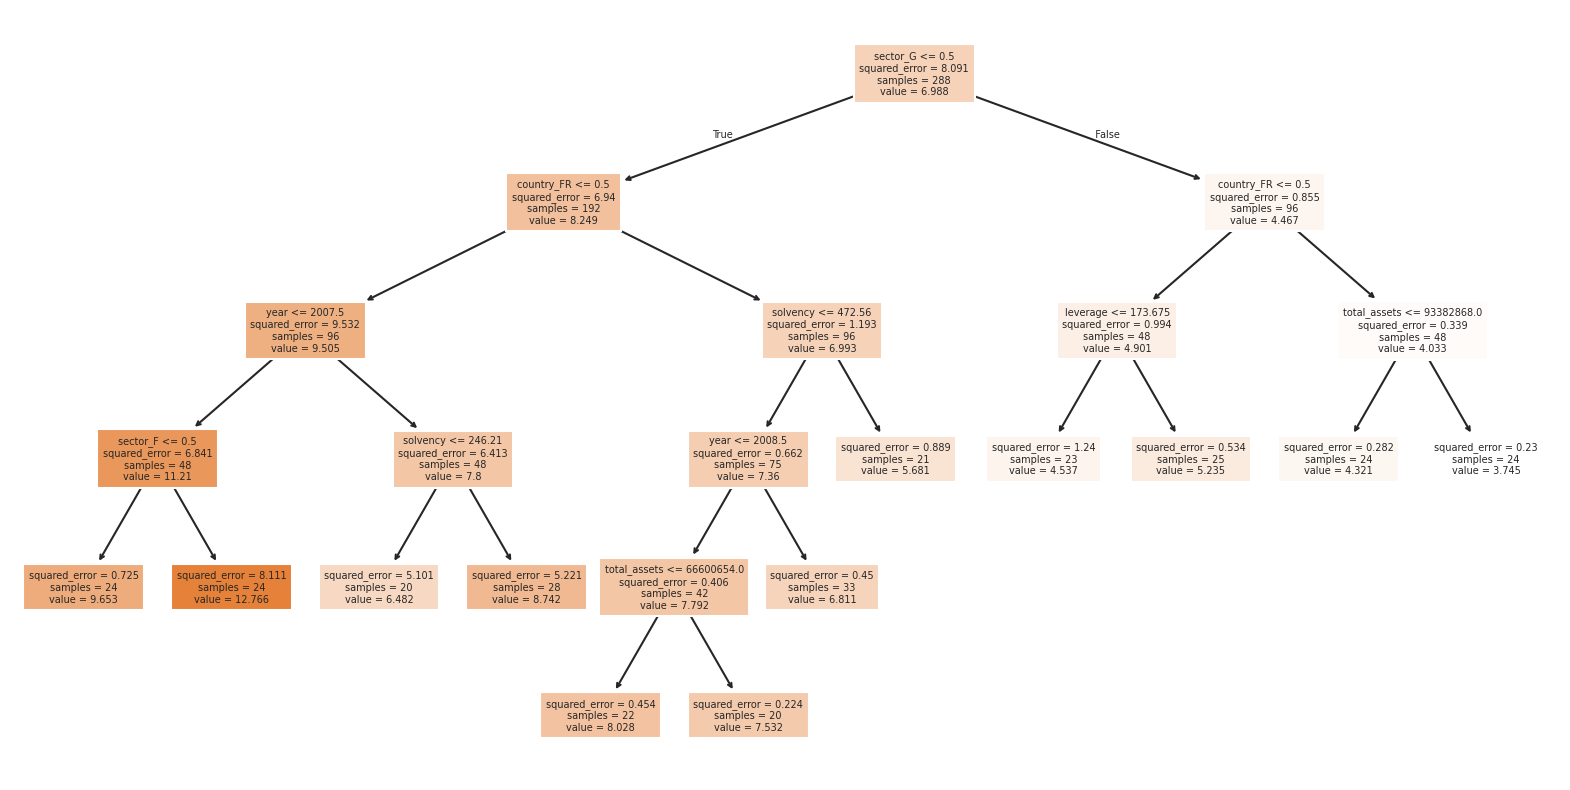

In [9]:
# === Rutas de artefactos ===
MODEL_DIR = Path(PATHS["out_models"])
MODEL_PATH = MODEL_DIR / "tree_reg_ebitda_time.pkl"

# === Variables ===
y_var = "ebitda_net_income"
cat_vars = ["country", "year", "sector", "size"]
num_vars = ["total_assets", "solvency", "leverage"]

# === Cargar datos procesados ===
df_tree = pd.read_csv(Path(PATHS["data_proc"]) / "empresas_limpio.csv").copy()

# --- Winsorización p1–p99 en numéricas ---
for col in num_vars:
    if col in df_tree.columns:
        w = winsorize(df_tree[col].values, limits=[0.01, 0.01])
        df_tree[col] = np.asarray(w, dtype=float)

# --- One-hot encoding de categóricas ---
df_tree_enc = pd.get_dummies(df_tree[cat_vars + num_vars], drop_first=True)

# --- Target y matriz de predictores ---
y_data = df_tree[y_var].values
X_data = df_tree_enc.values
feature_names = df_tree_enc.columns

# === Partición temporal (2000–2015 train, 2016–2019 test) ===
train_mask = df_tree["year"] <= 2015
X_train, X_test = X_data[train_mask], X_data[~train_mask]
y_train, y_test = y_data[train_mask], y_data[~train_mask]

# === Entrenar o cargar según modo ===
if RUN_MODELING:
    tree_model = DecisionTreeRegressor(
        max_depth=5, min_samples_leaf=20, random_state=42
    )
    tree_model.fit(X_train, y_train)
    joblib.dump({"model": tree_model, "features": feature_names}, MODEL_PATH)
else:
    payload = joblib.load(MODEL_PATH)
    tree_model = payload["model"]
    feature_names = payload["features"]

# === Métricas ===
y_pred = tree_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# === Importancia de variables ===
importances = pd.Series(tree_model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)
print("\nTop-10 importancias:")
print(importances.head(10))

# === Visualización del árbol===
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=feature_names, filled=True, fontsize=7)
plt.show()

### Conclusiones del modelo de árbol de regresión

En este apartado hemos desarrollado un modelo predictivo basado en **árbol de decisión de regresión** para estimar el ratio `ebitda_net_income` a partir de variables estructurales (`country`, `year`, `sector`, `size`, `total_assets`, `solvency` y `leverage`).  

Inicialmente probamos varias configuraciones:
- **Árbol con partición estratificada por `year`** (entrenamiento y test con representación proporcional de todos los años).  
- **Árbol con transformación logarítmica de `total_assets`** para reducir asimetría.  

Tras analizar los resultados, decidimos **eliminar estos modelos del informe** para ganar claridad, ya que:
- El modelo con `log(total_assets)` no mostró mejoras significativas en métricas ni en la relevancia de las variables.
- El árbol con partición estratificada temporalmente no representaba de forma realista un escenario de predicción a futuro.

Finalmente, realizamos una **winsorización** de las variables numéricas al percentil 1–99 para mitigar el efecto de valores extremos y un **one-hot encoding** para transformar las variables categóricas en formato numérico.   Además, optamos por una **partición temporal estricta** (train: 2000–2015, test: 2016–2019) para simular un contexto real de predicción sobre datos futuros, aunque esto penalice el ajuste.  
El modelo resultante obtuvo:
- **RMSE:** 1.5675  
- **R²:** 0.4000  

El modelo ha revelado una fuerte dependencia de ciertas variables categóricas, mientras que las numéricas han tenido un peso menor en la predicción inicial.  
En el ranking de importancia de variables, destacan:

1. **`sector_G`** como factor principal (**51,8%** de la importancia total).
2. **`country_FR`** (**18,2%**) y **`year`** (**16,8%**) como determinantes secundarios.
3. Entre las numéricas, **`solvency`** (**6,0%**) y **`total_assets`** (**0,4%**) aparecen con contribuciones reducidas.
4. Variables como **`size`** y **`leverage`** no han mostrado peso en el modelo.

Para mejorar el rendimiento manteniendo un modelo interpretable, afinamos un **árbol de decisión** con un **RandomizedSearchCV** sobre:
`max_depth`, `min_samples_leaf`, `min_samples_split` y `criterion`.

**Esquema de validación**  
- **Partición temporal fija** para evaluación: **train = 2000–2015**, **test = 2016–2019**.  
- Dentro del **train**, usamos **GroupKFold por `year`** (sin mezclar años entre folds), evitando fuga temporal durante el tuning.

**Preprocesado**  
- **Clipping p1–p99** (calculado en train) en `total_assets`, `solvency`, `leverage`.  
- **One-hot encoding** y alineación de columnas entre train/test.  


In [10]:
# 5.2 RandomizedSearchCV para DecisionTreeRegressor con validación temporal


# --- Configuración y datos ---
PROC = Path(PATHS["data_proc"]) / "empresas_limpio.csv"
df_all = pd.read_csv(PROC).copy()

y_var = "ebitda_net_income"
cat_vars = ["country", "year", "sector", "size"]
num_vars = ["total_assets", "solvency", "leverage"]

# Partición temporal fija
train_mask = df_all["year"] <= 2015
df_train = df_all.loc[train_mask].copy()
df_test  = df_all.loc[~train_mask].copy()

# --- Clipping p1–p99 SOLO con información de train ---
clip_info = {}
for col in num_vars:
    q_low  = df_train[col].quantile(0.01)
    q_high = df_train[col].quantile(0.99)
    clip_info[col] = (float(q_low), float(q_high))
    df_train[col] = df_train[col].clip(q_low, q_high)
    df_test[col]  = df_test[col].clip(q_low, q_high)

# --- One-hot y alineación de columnas ---
X_train = pd.get_dummies(df_train[cat_vars + num_vars], drop_first=True)
X_test  = pd.get_dummies(df_test[cat_vars + num_vars], drop_first=True)
# Alinear columnas de test al espacio de train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = df_train[y_var].values
y_test  = df_test[y_var].values
feature_names = X_train.columns.tolist()

# --- Búsqueda aleatoria con GroupKFold por 'year' (en el train) ---
param_distributions = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_leaf": randint(1, 31),      # 1..30
    "min_samples_split": randint(2, 21),     # 2..20
    "criterion": ["squared_error", "absolute_error"],  # MSE o MAE
}

cv = GroupKFold(n_splits=4)
groups = df_train["year"].astype(str).values  # agrupa por año

base_tree = DecisionTreeRegressor(random_state=42)
search = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=param_distributions,
    n_iter=16,
    scoring="neg_mean_squared_error",  # compatible con versiones antiguas
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0,
)

MODEL_DIR = Path(PATHS["out_models"])
MODEL_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_PATH = MODEL_DIR / "tree_reg_ebitda_time_tuned.pkl"

if RUN_MODELING:
    search.fit(X_train, y_train, groups=groups)
    best_model = search.best_estimator_

    # Guardar artefactos + metadatos de preprocesado
    payload = {
        "model": best_model,
        "feature_names": feature_names,
        "clip_info": clip_info,
        "cat_vars": cat_vars,
        "num_vars": num_vars,
        "y_var": y_var,
        "params": best_model.get_params(),
        "cv_best_rmse": float(np.sqrt(-search.best_score_)),
    }
    joblib.dump(payload, BEST_MODEL_PATH)
else:
    payload = joblib.load(BEST_MODEL_PATH)
    best_model   = payload["model"]
    feature_names = payload["feature_names"]
    clip_info     = payload["clip_info"]

# --- Evaluación en test temporal (2016–2019) ---
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("== Tuning del árbol (validación sin fuga temporal) ==")
if RUN_MODELING:
    print("Mejores hiperparámetros:", payload["params"])
    print(f"CV best RMSE (train, GroupKFold por year): {payload['cv_best_rmse']:.4f}")
else:
    print("Modelo cargado de artefacto:", BEST_MODEL_PATH.name)

print(f"Test RMSE (2016–2019): {rmse:.4f}")
print(f"Test R²   (2016–2019): {r2:.4f}")

# Importancia de variables (top 10)
importances = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop-10 importancias (mejor árbol):")
print(importances.head(10))

== Tuning del árbol (validación sin fuga temporal) ==
Mejores hiperparámetros: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
CV best RMSE (train, GroupKFold por year): 0.9617
Test RMSE (2016–2019): 1.2257
Test R²   (2016–2019): 0.6332

Top-10 importancias (mejor árbol):
sector_G        0.422459
leverage        0.150938
country_FR      0.148113
year            0.142367
size            0.101886
solvency        0.021633
total_assets    0.012604
sector_F        0.000000
dtype: float64


### Resultados finales tras el ajuste de hiperparámetros

Tras aplicar un proceso de **tuning de hiperparámetros** mediante búsqueda aleatoria y validación cruzada **GroupKFold** agrupada por año (evitando fuga temporal), hemos conseguido mejorar significativamente el rendimiento del modelo de árbol de regresión.  

Los mejores hiperparámetros encontrados fueron:  
- `max_depth`: 5  
- `min_samples_leaf`: 4  
- `min_samples_split`: 15  
- `criterion`: `"squared_error"`  
- Resto de parámetros en valores por defecto, salvo `random_state=42` para reproducibilidad.  

Con esta configuración, el modelo ha alcanzado:  
- **RMSE (CV best, train):** 0.9617  
- **RMSE (test 2016–2019):** 1.2257  
- **R² (test 2016–2019):** 0.6332  

Este incremento de R² respecto a la versión inicial (≈0,40) confirma que la optimización de hiperparámetros ha permitido mejorar la capacidad predictiva del árbol, manteniendo un modelo interpretable y sin sobreajustar a datos futuros.  

En cuanto a la **importancia de variables**, el patrón final es más equilibrado:  
1. **`sector_G`** (42,2%) como principal predictor.  
2. **`leverage`** (15,1%), **`country_FR`** (14,8%) y **`year`** (14,2%) como factores secundarios de peso similar.  
3. **`size`** (10,2%) gana relevancia respecto a modelos anteriores.  
4. **`solvency`** (2,2%) y **`total_assets`** (1,3%) mantienen una contribución reducida.  

Con estos resultados, **este será el modelo con el que trabajaremos en adelante**, ya que ofrece un compromiso sólido entre rendimiento, realismo en la evaluación y facilidad de interpretación.  

En un escenario orientado exclusivamente a maximizar precisión, podríamos explorar técnicas de ensamble como **Random Forest** o **Gradient Boosting**, que probablemente elevarían el R², especialmente con más variables y ajustes finos.

## 6.Efecto causal de *Leverage* (alto vs. bajo) sobre `ebitda_net_income` con árboles

**Objetivo.** Estimar el **CATE** (*Conditional Average Treatment Effect*) del *apalancamiento financiero* (**Leverage**) sobre `ebitda_net_income`, **controlando** por el resto de variables observables: `total_assets`, `solvency` y las categóricas `country`, `sector`, `size`, `year`.

**Definición del tratamiento.** Creamos una variable binaria:
- `T = 1` (*Leverage alto*) si el `leverage` de una observación **supera o iguala** el **percentil 50 por sector** (mediana **calculada sobre el conjunto de entrenamiento**).
- `T = 0` en caso contrario (*Leverage bajo*).

Esta regla por sector busca un umbral **equilibrado y comparable** entre actividades con niveles típicos de apalancamiento distintos.

**Metodología (T-learner con árboles).**
1. Partición temporal (como en el bloque predictivo): **train = 2000–2015**, **test = 2016–2019**.
2. Preprocesado **solo con información de train**:
   - *Clipping* p1–p99 en `total_assets`, `solvency`, `leverage` (mitigar outliers).
   - *One-hot* de categóricas con alineación de columnas entre train/test.
3. Estimamos dos modelos de **árbol de regresión**:
   - `f1(x)`: entrenado **solo con tratados** (T=1) para aproximar el resultado potencial *con* tratamiento.
   - `f0(x)`: entrenado **solo con control** (T=0) para aproximar el resultado potencial *sin* tratamiento.
4. Para cada observación del test, el **CATE** se estima como:  
  $$
\widehat{\mathrm{CATE}}(x)=\hat{y}_{1}(x)-\hat{y}_{0}(x)
$$
5. Reportamos:
   - **ATE (media del CATE)** y percentiles (p10, p50, p90) en test.
   - **CATE por subgrupos** (`country`, `sector`, `size`).
   - Histograma/boxplots de CATE.

**Reproducibilidad.** En `RUN_MODELING=True` entrenamos y guardamos:
- Árboles `f1` y `f0`, umbrales por sector, *clip info* y columnas (*one-hot*).
- CSV con CATE a nivel de observación y resúmenes por subgrupos.
En `RUN_MODELING=False` **cargamos** esos artefactos para evitar recalcular.

**Supuestos clave (enunciado).** Interpretamos el efecto como causal bajo:
- **Ignorabilidad condicional**: dado el conjunto de controles, el tratamiento es “como aleatorio”.
- **Solapamiento**: existen unidades comparables en T=1 y T=0.
- **SUTVA**: no hay interferencia entre unidades ni múltiples versiones del tratamiento.

Train balance → T=1: 144 | T=0: 144

=== CATE en test (2016–2019). Interpretación: CATE = efecto de Leverage ALTO ===
ATE (media CATE): 0.1857
Percentiles CATE (p10, p50, p90): -1.7924, -0.2981, 3.2706

CSV guardados:
- /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/outputs/csv/cate_test_rows.csv
- /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/outputs/csv/cate_test_groups.csv


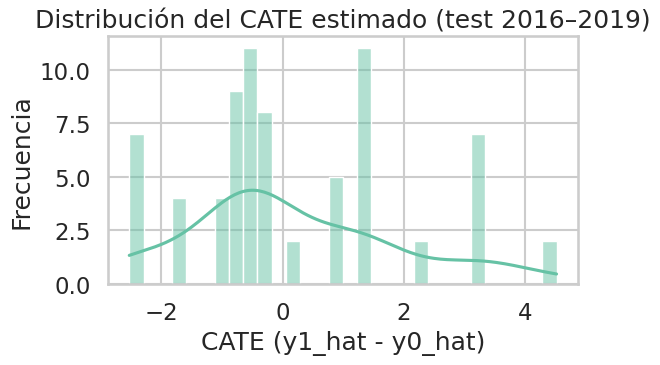

Figura guardada en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej5_finanzas_causal_predictivo/outputs/figures/cate_hist.png


In [13]:
# 6) CATE de Leverage alto vs bajo con T-learner (árboles de decisión)

# --- Configuración de rutas ---
PROC = Path(PATHS["data_proc"]) / "empresas_limpio.csv"
OUT_MODELS = Path(PATHS["out_models"]); OUT_MODELS.mkdir(parents=True, exist_ok=True)
OUT_CSV    = Path(PATHS["out_csv"]);    OUT_CSV.mkdir(parents=True, exist_ok=True)
OUT_FIGS   = Path(PATHS["out_figs"]);   OUT_FIGS.mkdir(parents=True, exist_ok=True)

ARTEFACTO = OUT_MODELS / "cate_tlearner_trees.pkl"
CATE_CSV  = OUT_CSV / "cate_test_rows.csv"
CATE_GRP  = OUT_CSV / "cate_test_groups.csv"
CATE_FIG  = OUT_FIGS / "cate_hist.png"

# --- Variables ---
y_var    = "ebitda_net_income"
cat_vars = ["country", "sector", "size", "year"]  # year lo tratamos como categórica (one-hot) por coherencia
num_vars = ["total_assets", "solvency", "leverage"]
treat_var = "leverage"   # continuo; se binariza a T usando mediana por sector (calculada en train)

# --- Lectura de datos completos ---
df_all = pd.read_csv(PROC).copy()

# --- Split temporal coherente con el bloque predictivo ---
train_mask = df_all["year"] <= 2015
df_train = df_all.loc[train_mask].copy()
df_test  = df_all.loc[~train_mask].copy()

# --- Definir tratamiento: mediana por sector calculada en TRAIN ---
sector_median = df_train.groupby("sector")[treat_var].median().to_dict()
global_median = df_train[treat_var].median()

def leverage_high(row):
    thr = sector_median.get(row["sector"], global_median)
    return 1 if row[treat_var] >= thr else 0

df_train["T"] = df_train.apply(leverage_high, axis=1)
df_test["T"]  = df_test.apply(leverage_high, axis=1)

# Info de balance
n_treat_tr, n_ctrl_tr = df_train["T"].sum(), (1 - df_train["T"]).sum()
print(f"Train balance → T=1: {n_treat_tr} | T=0: {n_ctrl_tr}")

# --- Preprocesado SOLO con info de TRAIN: clipping p1–p99 en numéricas ---
clip_info = {}
for col in num_vars:
    q1 = float(df_train[col].quantile(0.01)); q99 = float(df_train[col].quantile(0.99))
    clip_info[col] = (q1, q99)
    df_train[col] = df_train[col].clip(q1, q99)
    df_test[col]  = df_test[col].clip(q1, q99)

# --- One-hot encoding & alineación de columnas (train como referencia) ---
X_train_full = pd.get_dummies(df_train[cat_vars + num_vars], drop_first=True)
X_test_full  = pd.get_dummies(df_test[cat_vars + num_vars],  drop_first=True)
X_test_full  = X_test_full.reindex(columns=X_train_full.columns, fill_value=0)

y_train = df_train[y_var].values
y_test  = df_test[y_var].values

# --- Subconjuntos para T-learner (solo train) ---
X1 = X_train_full[df_train["T"] == 1]
y1 = df_train.loc[df_train["T"] == 1, y_var].values

X0 = X_train_full[df_train["T"] == 0]
y0 = df_train.loc[df_train["T"] == 0, y_var].values

if RUN_MODELING:
    # Hiperparámetros sobrios (interpretables) — puedes ajustar si lo ves necesario
    base_params = dict(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       criterion="squared_error", random_state=42)

    f1 = DecisionTreeRegressor(**base_params).fit(X1, y1)  # resultado potencial con tratamiento
    f0 = DecisionTreeRegressor(**base_params).fit(X0, y0)  # resultado potencial sin tratamiento

    payload = {
        "f1": f1, "f0": f0,
        "feature_names": X_train_full.columns.tolist(),
        "sector_median": sector_median, "global_median": global_median,
        "clip_info": clip_info, "cat_vars": cat_vars, "num_vars": num_vars,
        "y_var": y_var, "treat_var": treat_var
    }
    joblib.dump(payload, ARTEFACTO)
else:
    payload = joblib.load(ARTEFACTO)
    f1, f0 = payload["f1"], payload["f0"]

# --- Cálculo de CATE en TEST ---
# (Aplicamos los modelos entrenados en train a TODO el test)
y1_hat = f1.predict(X_test_full)
y0_hat = f0.predict(X_test_full)
cate   = y1_hat - y0_hat  # CATE(x) estimado

# --- Resumen global ---
ate = float(np.mean(cate))
p10, p50, p90 = np.percentile(cate, [10, 50, 90])

print("\n=== CATE en test (2016–2019). Interpretación: CATE = efecto de Leverage ALTO ===")
print(f"ATE (media CATE): {ate:.4f}")
print(f"Percentiles CATE (p10, p50, p90): {p10:.4f}, {p50:.4f}, {p90:.4f}")

# --- CATE por subgrupos (country, sector, size) ---
df_out = df_test[["country", "sector", "size", "year", "leverage", y_var, "T"]].copy()
df_out["y1_hat"] = y1_hat
df_out["y0_hat"] = y0_hat
df_out["cate"]   = cate

grp_country = df_out.groupby("country")["cate"].agg(["count","mean","median","std"]).reset_index()
grp_sector  = df_out.groupby("sector")["cate"].agg(["count","mean","median","std"]).reset_index()
grp_size    = df_out.groupby("size")["cate"].agg(["count","mean","median","std"]).reset_index()

grp_country["group"] = "country"; grp_sector["group"] = "sector"; grp_size["group"] = "size"
grp_country.rename(columns={"country":"level"}, inplace=True)
grp_sector.rename(columns={"sector":"level"}, inplace=True)
grp_size.rename(columns={"size":"level"}, inplace=True)
grp_all = pd.concat([grp_country, grp_sector, grp_size], ignore_index=True)

# --- Guardar salidas ---
df_out.to_csv(CATE_CSV, index=False, encoding="utf-8")
grp_all.to_csv(CATE_GRP, index=False, encoding="utf-8")
print(f"\nCSV guardados:\n- {CATE_CSV}\n- {CATE_GRP}")

# --- Visualización rápida del CATE ---
plt.figure(figsize=(6,4))
sns.histplot(df_out["cate"], bins=30, kde=True)
plt.title("Distribución del CATE estimado (test 2016–2019)")
plt.xlabel("CATE (y1_hat - y0_hat)"); plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig(CATE_FIG, dpi=120)
plt.show()
print(f"Figura guardada en: {CATE_FIG}")

### Interpretación global del efecto causal del leverage

En esta fase hemos estimado el efecto causal del apalancamiento financiero (**Leverage alto vs. Leverage bajo**) sobre el ratio **EBITDA/Ingresos netos**, controlando por el resto de variables observables.  

Los resultados obtenidos para el periodo de test (2016–2019) son los siguientes:

- **ATE (Average Treatment Effect):** 0.1857  
  → En promedio, las empresas con *Leverage alto* presentan un ratio EBITDA/Ingresos netos ligeramente superior (≈0,19 unidades) respecto a las de *Leverage bajo*.  

- **Percentiles del CATE:**  
  - p10 = -1.79 → en el 10% de las observaciones, el apalancamiento alto reduce notablemente la rentabilidad relativa.  
  - p50 = -0.30 → la mediana muestra un efecto levemente negativo, lo que indica que en la mayoría de casos el leverage alto no resulta beneficioso.  
  - p90 = 3.27 → en el 10% superior, el efecto es muy positivo, reflejando que existen subgrupos de empresas donde el leverage alto impulsa de manera significativa la rentabilidad operativa.  

Estos resultados ponen de manifiesto la **heterogeneidad del impacto del leverage**: aunque el efecto medio es positivo, existen diferencias importantes entre empresas. El histograma confirma esta dispersión, mostrando tanto efectos negativos como positivos en distintos casos.

En el siguiente punto analizaremos los **efectos por subgrupos (país, sector, tamaño)** utilizando los resultados almacenados en `cate_test_groups.csv`, con el fin de identificar en qué contextos el apalancamiento resulta más o menos favorable.

## 7.Resultados por subgrupos (país, sector, tamaño)

=== Resultados por subgrupo ===


,level,count,mean,median,std,group
0,ES,36,1.052611,0.907000,1.726973,country
1,FR,36,-0.681139,-0.653824,1.254239,country
2,C,24,0.916819,1.308401,1.438755,sector
3,F,24,-0.033345,-0.585253,2.180774,sector
4,G,24,-0.326266,-0.298077,1.256046,sector
5,1,24,0.945862,0.578727,1.542650,size
6,2,24,-0.186396,-0.407380,1.153591,size
7,3,24,-0.202258,-0.795566,2.160961,size



=== Primeras filas con CATE individuales ===


,country,sector,size,year,leverage,ebitda_net_income,T,y1_hat,y0_hat,cate
0,ES,C,1,2016,105.8300,7.80,0,8.575625,5.305000,3.270625
1,ES,C,2,2016,104.8341,10.33,0,8.575625,9.092308,-0.516683
2,ES,C,3,2016,147.7300,9.98,0,8.575625,6.374545,2.201080
3,ES,F,1,2016,113.6700,6.21,0,8.575625,5.305000,3.270625
4,ES,F,2,2016,157.0000,9.22,0,8.575625,9.092308,-0.516683
5,ES,F,3,2016,399.6200,7.77,1,11.794615,7.278824,4.515792
6,ES,G,1,2016,134.0800,4.27,0,5.025000,3.735000,1.290000
7,ES,G,2,2016,125.6800,4.97,0,5.025000,4.118000,0.907000
8,ES,G,3,2016,160.5500,6.83,0,5.025000,5.962308,-0.937308
9,ES,C,1,2017,104.8341,7.89,0,8.575625,5.305000,3.270625


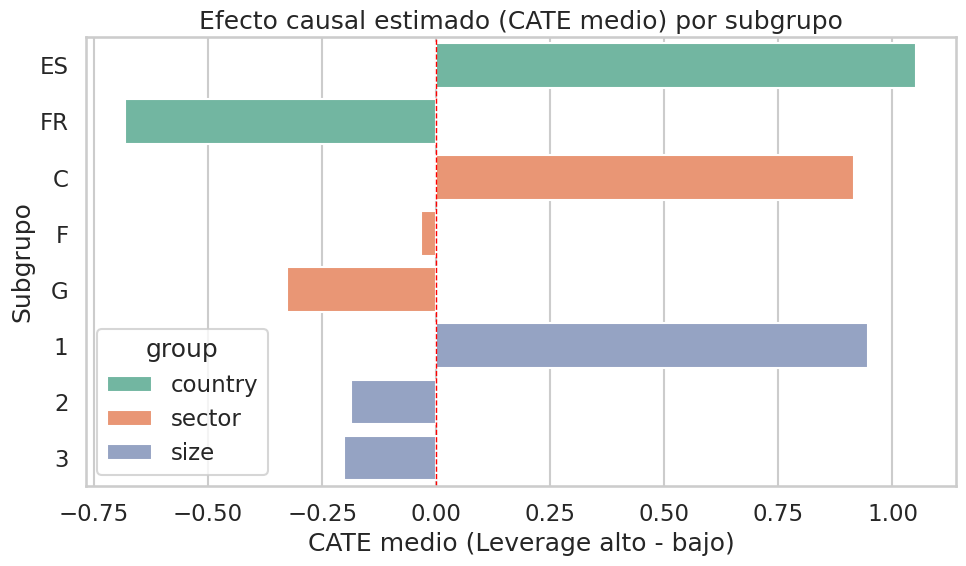

=== Resumen de CATE medio por subgrupo ===


,group,level,mean,median,std,count
0,country,ES,1.053,0.907,1.727,36
1,size,1,0.946,0.579,1.543,24
2,sector,C,0.917,1.308,1.439,24
3,sector,F,-0.033,-0.585,2.181,24
4,size,2,-0.186,-0.407,1.154,24
5,size,3,-0.202,-0.796,2.161,24
6,sector,G,-0.326,-0.298,1.256,24
7,country,FR,-0.681,-0.654,1.254,36


In [22]:
# === Punto 7. Resultados por subgrupos (país, sector, tamaño) ===

# Cargar resultados guardados de CATE
df_groups = pd.read_csv(Path(PATHS["out_csv"]) / "cate_test_groups.csv")
df_rows   = pd.read_csv(Path(PATHS["out_csv"]) / "cate_test_rows.csv")

print("=== Resultados por subgrupo ===")
display(df_groups.head(10))

print("\n=== Primeras filas con CATE individuales ===")
display(df_rows.head(10))

# Gráfico de barras: efecto medio por subgrupo
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_groups,
    x="mean",
    y="level",
    hue="group",
    dodge=False
)
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("Efecto causal estimado (CATE medio) por subgrupo")
plt.xlabel("CATE medio (Leverage alto - bajo)")
plt.ylabel("Subgrupo")
plt.tight_layout()
plt.show()

# Crear tabla resumen ordenada por CATE medio ordenado de mayor efecto positivo al más negativo
df_summary = (
    df_groups[["group", "level", "mean", "median", "std", "count"]]
    .sort_values(by="mean", ascending=False)
    .round(3)
    .reset_index(drop=True)
)

print("=== Resumen de CATE medio por subgrupo ===")
display(df_summary)

### Resultados del efecto causal por subgrupos (CATE)

Tras estimar el **Conditional Average Treatment Effect (CATE)** del apalancamiento financiero alto vs. bajo sobre el ratio *EBITDA/Ingresos netos*, obtenemos diferencias relevantes según país, sector y tamaño de las empresas.  

Los resultados muestran lo siguiente:

- **Por país**:  
  - En **España (ES)** el efecto medio es **positivo y elevado** (+1,05), indicando que un mayor apalancamiento se asocia con un incremento del rendimiento operativo.  
  - En **Francia (FR)** el efecto medio es **negativo** (-0,68), lo que sugiere que un mayor endeudamiento reduce la rentabilidad en este contexto.  

- **Por sector**:  
  - En el **sector C** el efecto es claramente **positivo** (+0,92), con mediana incluso superior a 1,3.  
  - En el **sector F** el efecto es prácticamente **nulo** (media ≈ 0,0), aunque con alta dispersión (desviación > 2,1).  
  - En el **sector G** el efecto medio es **ligeramente negativo** (-0,33).  

- **Por tamaño**:  
  - Las **empresas pequeñas (size=1)** muestran un **efecto positivo notable** (+0,95), lo que sugiere que el apalancamiento puede ayudar a impulsar su EBITDA/Ingresos netos.  
  - Las de tamaño **medio (size=2)** y **grande (size=3)** presentan efectos **negativos** (-0,19 y -0,20 respectivamente), lo que apunta a que en organizaciones más grandes un mayor endeudamiento no se traduce en mejor rendimiento operativo.  

En conjunto, se observa que el impacto del apalancamiento es **heterogéneo**:  
- Beneficioso en España, en el sector C y en empresas pequeñas.  
- Negativo en Francia y en compañías de mayor tamaño.  
- Neutro o incierto en sectores como F y G.  

Esto resalta la importancia de considerar el **contexto empresarial y sectorial** antes de recomendar políticas de financiación basadas en mayor deuda.

## 8.Conclusiones generales del ejercicio

En este ejercicio hemos desarrollado un análisis completo para estudiar el impacto de las características estructurales de las empresas sobre el ratio **EBITDA/Ingresos netos** y, en particular, para evaluar el efecto causal del apalancamiento financiero.  

El proceso ha seguido varias etapas:  
1. **Establecimiento de un baseline** con un modelo de regresión lineal, que sirvió como referencia inicial y permitió constatar sus limitaciones para capturar la complejidad del fenómeno.  
2. **Construcción de un modelo predictivo** mediante un árbol de regresión, donde se probaron distintas configuraciones (estratificación por año, transformación logarítmica de activos totales). Tras comparar alternativas, se optó por un enfoque con **partición temporal estricta** (train: 2000–2015, test: 2016–2019) y posterior **ajuste de hiperparámetros**, lo que permitió mejorar las métricas hasta alcanzar un **R² ≈ 0.63** en test.  
3. **Interpretación de la importancia de las variables**, identificando a `sector`, `country`, `year` y `leverage` como los principales determinantes del rendimiento operativo en el modelo ajustado.  
4. **Estimación del efecto causal (CATE)** del apalancamiento alto frente a bajo, controlando por el resto de variables. Para ello se aplicaron modelos basados en árboles, obteniendo tanto una medida global (ATE ≈ 0.19) como resultados específicos por subgrupos.  
5. **Análisis de heterogeneidad por país, sector y tamaño**, que permitió detectar diferencias sustanciales en cómo impacta el endeudamiento en cada contexto.  

En síntesis, los resultados muestran que el apalancamiento financiero no tiene un efecto uniforme sobre la rentabilidad: **su impacto depende del contexto empresarial y sectorial**. Esto implica que las decisiones de financiación deben adaptarse a las características de cada compañía y no plantearse como una estrategia homogénea para todos los casos.